# ECE 228 Project
### Mike Liu, Maxime Ghesquiere, Merve Kilic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Remember to give permission and what nots

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#IMPORT LINES
import pickle
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import os

In [ ]:
#Put shared drive shortcut in main drive
#Create (if not already) a folder called "Colab Notebooks"
#Acess all data through "path"
#Created a data folder, see "path2"
path = os.getcwd()
#path = path + '/drive/MyDrive/ECE 228/ECE 228 Project/'
path = path + '/drive/MyDrive/Colab Notebooks/ECE 228 Project/'
# path2 = path + 'data/'
# files = os.listdir(path2)

#load files like you do normally with relative or absolute paths


In [ ]:
Img_File_Extensions = [
    '.jpg',
    '.JPG',
    '.jpeg',
    '.JPEG',
    '.png',
    '.PNG',
    '.ppm',
    '.PPM',
    '.bmp',
    '.BMP',
    '.tiff',
    '.TIFF',
]


def is_image(file):
    return any(file.endswith(extension) for extension in Img_File_Extensions)

class MyDataloader(torch.utils.data.Dataset):
  def __init__(self,data_root,transforms=None):
    self.files = []
    self.root = data_root
    all_files = os.listdir(data_root)
    self.files = [i for i in all_files if is_image(i)]
    self.transforms = transforms
  def __len__(self):
    return len(self.files)
  def __getitem__(self,idx):
    file = os.path.join(self.root,self.files[idx])
    raw_im = np.array(Image.open(file))
    raw_im[np.where(raw_im==0)]=np.nan
    m = np.nanmean(raw_im)
    raw_im = np.nan_to_num(raw_im,nan=m)
    if self.transforms:
      raw_im = self.transforms(raw_im)
    input_im = []#raw_im["whatever indeces we want to crop out of the center"]
    metadata = self.files[idx] #need to edit this to have the correct numbers, will work on this later
    return metadata,input_im,raw_im


### Load Data

In [ ]:
dataset = MyDataloader(path2)

# Define the dimensions
num_samples = 32560
input_dim = 80 * 80
target_dim = 100 * 100

# Create empty matrices for input and target data
input_data = np.zeros((num_samples, input_dim))
target_data = np.zeros((num_samples, target_dim))
long_lat = np.zeros((num_samples, 2))

# Iterate over the dataset
for idx in range(num_samples):
    # Get the input and target data for the current index
    current = dataset.__getitem__(idx)
    input_sample = current[2].copy()
    target_sample = current[2].copy()

    # Get the longitude and latitude for the current index
    name = current[0]
    name = name.replace('.tiff', '')
    long_lat[idx] = [float(num) for num in name.split('_')]

    # Crop the input sample by 10 pixels on each side
    cropped_input_sample = input_sample[10:90, 10:90]

    # Reshape the input and target samples into row vectors
    input_vector = cropped_input_sample.reshape(1, -1)
    target_vector = target_sample.reshape(1, -1)

    # Assign the vectors to the corresponding rows in the data matrices
    input_data[idx] = input_vector
    target_data[idx] = target_vector

# Print the shapes of the input and target data matrices
print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)


with open(path+'input.pickle', 'wb') as handle:
    pickle.dump(input_data, handle)
with open(path+'target.pickle', 'wb') as handle:
    pickle.dump(target_data, handle)
with open(path+'long_lat.pickle', 'wb') as handle:
    pickle.dump(long_lat, handle)

KeyboardInterrupt: ignored

In [ ]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
with open(path+'input.pickle', 'rb') as handle:
    input_data = pickle.load(handle)

with open(path+'target.pickle', 'rb') as handle:
    target_data = pickle.load(handle)

with open(path+'long_lat.pickle', 'rb') as handle:
    long_lat = pickle.load(handle)

### Filter NaN data

In [ ]:
np.isin(True, np.isnan(target_data))

array(True)

In [ ]:
nan_list = np.argwhere(np.isnan(target_data))
unq_nan = np.unique(nan_list[:,0])

In [ ]:
filter_target_data = np.delete(target_data, unq_nan, 0)

In [ ]:
np.isin(True, np.isnan(filter_target_data))

array(False)

In [ ]:
with open(path+'filter_target.pickle', 'wb') as handle:
    pickle.dump(filter_target_data, handle)

In [ ]:
with open(path+'pickle/filter_target.pickle', 'rb') as handle:
    filter_target_data = pickle.load(handle)

In [ ]:
filter_input_data = filter_target_data.reshape(-1, 100, 100)[:, 10:90, 10:90].reshape(-1,80*80).copy()
filter_input_data.shape

(31791, 6400)

### Linear Regression Model

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filter_input_data, filter_target_data, test_size=0.3, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting new output contours
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
print('MSE: ', mean_squared_error(y_test, y_pred))

MSE:  5781.529108167358


In [ ]:
from skimage.metrics import structural_similarity as ssim

def ssim_score(y_test, y_pred):
  # Assuming you have ground truth data and predicted data as numpy arrays
  ground_truth_data = y_test.copy()
  predicted_data = y_pred.copy()

  # Apply min-max normalization to rescale the data to [0, 1]
  ground_truth_min = np.min(ground_truth_data)
  ground_truth_max = np.max(ground_truth_data)
  ground_truth_data = (ground_truth_data - ground_truth_min) / (ground_truth_max - ground_truth_min)

  predicted_min = np.min(predicted_data)
  predicted_max = np.max(predicted_data)
  predicted_data = (predicted_data - predicted_min) / (predicted_max - predicted_min)

  # Calculate SSIM for all pairs of ground truth and predicted data
  ssim_scores = ssim(ground_truth_data, predicted_data)

  # Compute and return the average SSIM score
  return np.mean(ssim_scores)


In [ ]:
print("Average SSIM:", ssim_score(y_test, y_pred))

Average SSIM: 0.8380988266455162


Text(0.5, 1.0, 'Predicted Output')

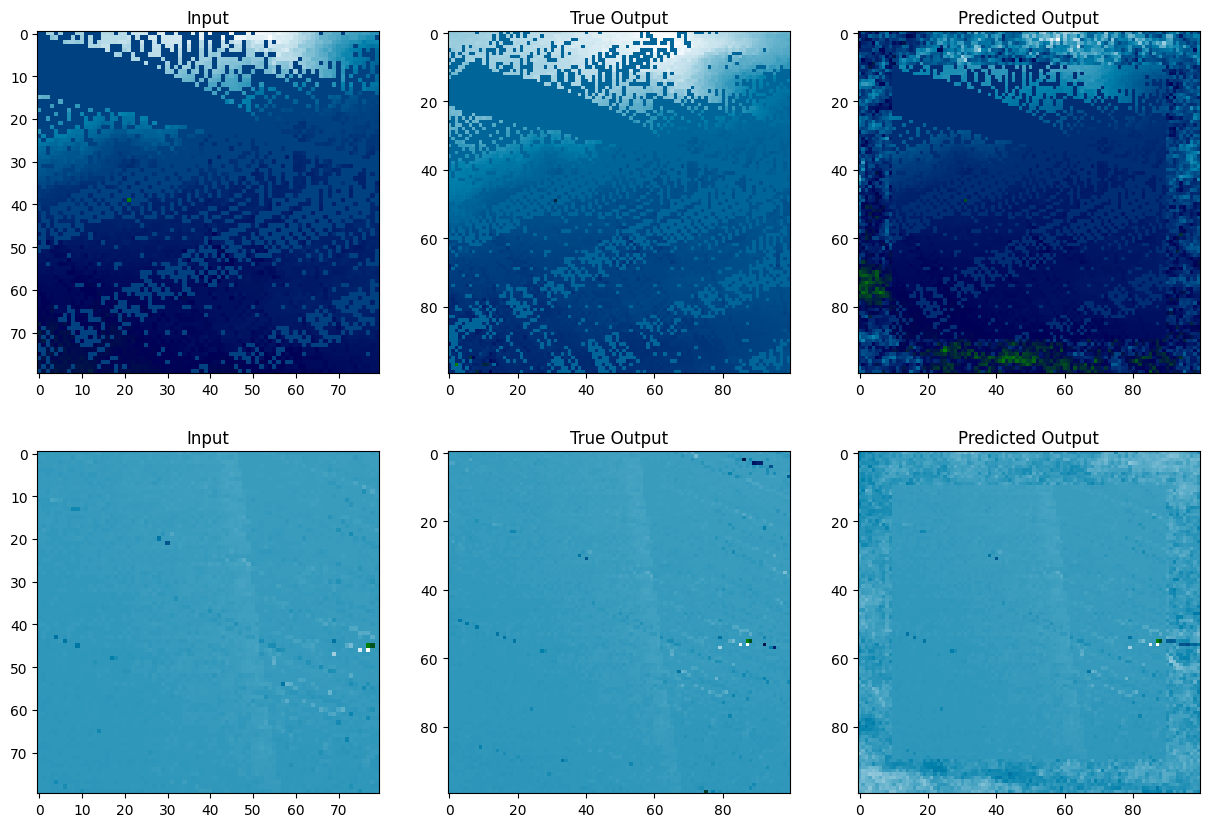

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(X_test[0].reshape(80,80),cmap='ocean')
ax1.set_title('Input')
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(y_test[0].reshape(100,100),cmap='ocean')
ax2.set_title('True Output')
ax3 = fig.add_subplot(2,3,3)
ax3.imshow(y_pred[0].reshape(100,100),cmap='ocean')
ax3.set_title('Predicted Output')
ax4 = fig.add_subplot(2,3,4)
ax4.imshow(X_test[-1].reshape(80,80),cmap='ocean')
ax4.set_title('Input')
ax5 = fig.add_subplot(2,3,5)
ax5.imshow(y_test[-1].reshape(100,100),cmap='ocean')
ax5.set_title('True Output')
ax6 = fig.add_subplot(2,3,6)
ax6.imshow(y_pred[-1].reshape(100,100),cmap='ocean')
ax6.set_title('Predicted Output')

Text(0.5, 1.0, 'Predicted Output')

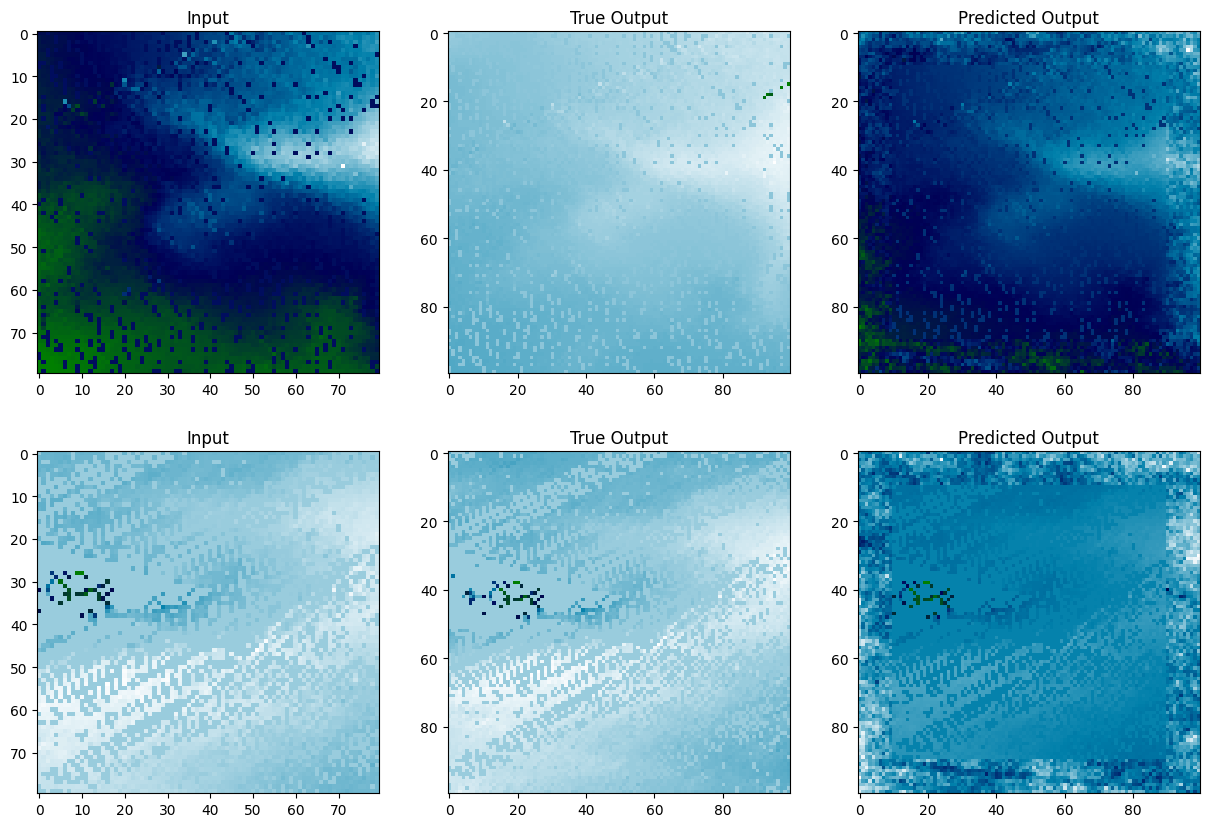

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(X_test[1000].reshape(80,80),cmap='ocean')
ax1.set_title('Input')
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(y_test[1000].reshape(100,100),cmap='ocean')
ax2.set_title('True Output')
ax3 = fig.add_subplot(2,3,3)
ax3.imshow(y_pred[1000].reshape(100,100),cmap='ocean')
ax3.set_title('Predicted Output')
ax4 = fig.add_subplot(2,3,4)
ax4.imshow(X_test[-1000].reshape(80,80),cmap='ocean')
ax4.set_title('Input')
ax5 = fig.add_subplot(2,3,5)
ax5.imshow(y_test[-1000].reshape(100,100),cmap='ocean')
ax5.set_title('True Output')
ax6 = fig.add_subplot(2,3,6)
ax6.imshow(y_pred[-1000].reshape(100,100),cmap='ocean')
ax6.set_title('Predicted Output')

## CNN


In [ ]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(filter_input_data, filter_target_data, test_size=0.3, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Creating the dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)

        # Activation function
        self.relu = nn.ReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 6400, 256)
        self.fc2 = nn.Linear(256, 10000)

    def forward(self, x):
        # Reshape the input to (batch_size, num_channels, sequence_length)
        x = x.unsqueeze(1)

        # Convolutional layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

model = CNN()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for t, (inputs, targets) in enumerate(train_dataloader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if t % 100 == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (epoch+1, t, loss.item()))

# Evaluation
with torch.no_grad():
    model.eval()

    # Make predictions on test data
    test_outputs = model(X_test_tensor)

    # Calculate the evaluation metric: MSE
    evaluation_metric = criterion(test_outputs, y_test_tensor)

    # Calculate the evaluation metric: SSIM
    ssim_score_cnn = ssim_score(test_outputs.numpy(), y_test_tensor.numpy())


# Print the evaluation metric
print("MSE:", evaluation_metric.item())
print("Average SSIM:", ssim_score_cnn)

# Save model
with open(path+'cnn_model.pickle', 'wb') as handle:
    pickle.dump(model, handle)

Epoch 1, Iteration 0, loss = 11092028.0000
Epoch 1, Iteration 100, loss = 9872351.0000
Epoch 1, Iteration 200, loss = 8035636.0000
Epoch 1, Iteration 300, loss = 8741863.0000
Epoch 1, Iteration 400, loss = 13316268.0000
Epoch 1, Iteration 500, loss = 8310636.5000
Epoch 1, Iteration 600, loss = 10206859.0000
Epoch 2, Iteration 0, loss = 9107602.0000
Epoch 2, Iteration 100, loss = 12557467.0000
Epoch 2, Iteration 200, loss = 8707816.0000
Epoch 2, Iteration 300, loss = 9244653.0000
Epoch 2, Iteration 400, loss = 10577791.0000
Epoch 2, Iteration 500, loss = 12338626.0000
Epoch 2, Iteration 600, loss = 7457490.5000
Epoch 3, Iteration 0, loss = 9853515.0000
Epoch 3, Iteration 100, loss = 9777775.0000
Epoch 3, Iteration 200, loss = 11570212.0000
Epoch 3, Iteration 300, loss = 7955873.0000
Epoch 3, Iteration 400, loss = 11808501.0000
Epoch 3, Iteration 500, loss = 10128945.0000
Epoch 3, Iteration 600, loss = 10958557.0000
Epoch 4, Iteration 0, loss = 10305693.0000
Epoch 4, Iteration 100, loss 

In [ ]:
y_pred_cnn = test_outputs.numpy()

Text(0.5, 1.0, 'Predicted Output')

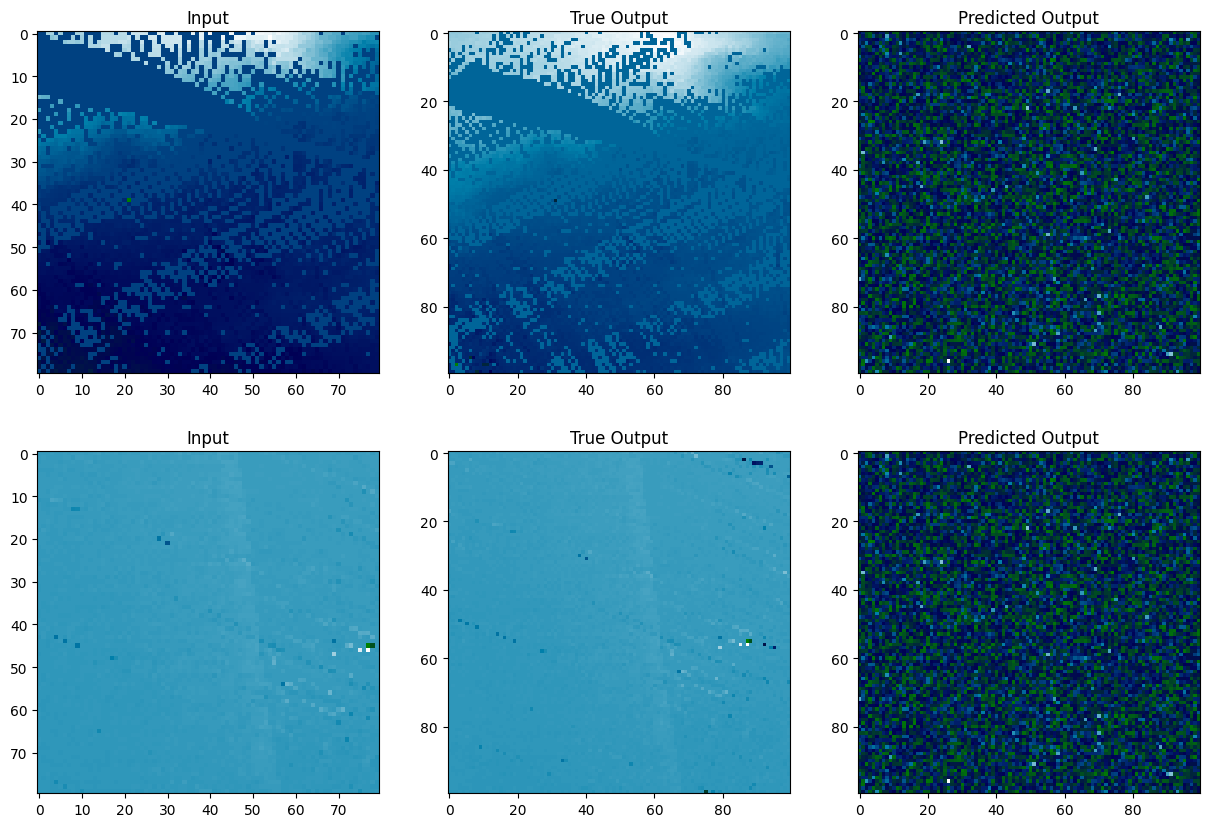

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(X_test[0].reshape(80,80),cmap='ocean')
ax1.set_title('Input')
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(y_test[0].reshape(100,100),cmap='ocean')
ax2.set_title('True Output')
ax3 = fig.add_subplot(2,3,3)
ax3.imshow(y_pred_cnn[0].reshape(100,100),cmap='ocean')
ax3.set_title('Predicted Output')
ax4 = fig.add_subplot(2,3,4)
ax4.imshow(X_test[-1].reshape(80,80),cmap='ocean')
ax4.set_title('Input')
ax5 = fig.add_subplot(2,3,5)
ax5.imshow(y_test[-1].reshape(100,100),cmap='ocean')
ax5.set_title('True Output')
ax6 = fig.add_subplot(2,3,6)
ax6.imshow(y_pred_cnn[-1].reshape(100,100),cmap='ocean')
ax6.set_title('Predicted Output')

Text(0.5, 1.0, 'Predicted Output')

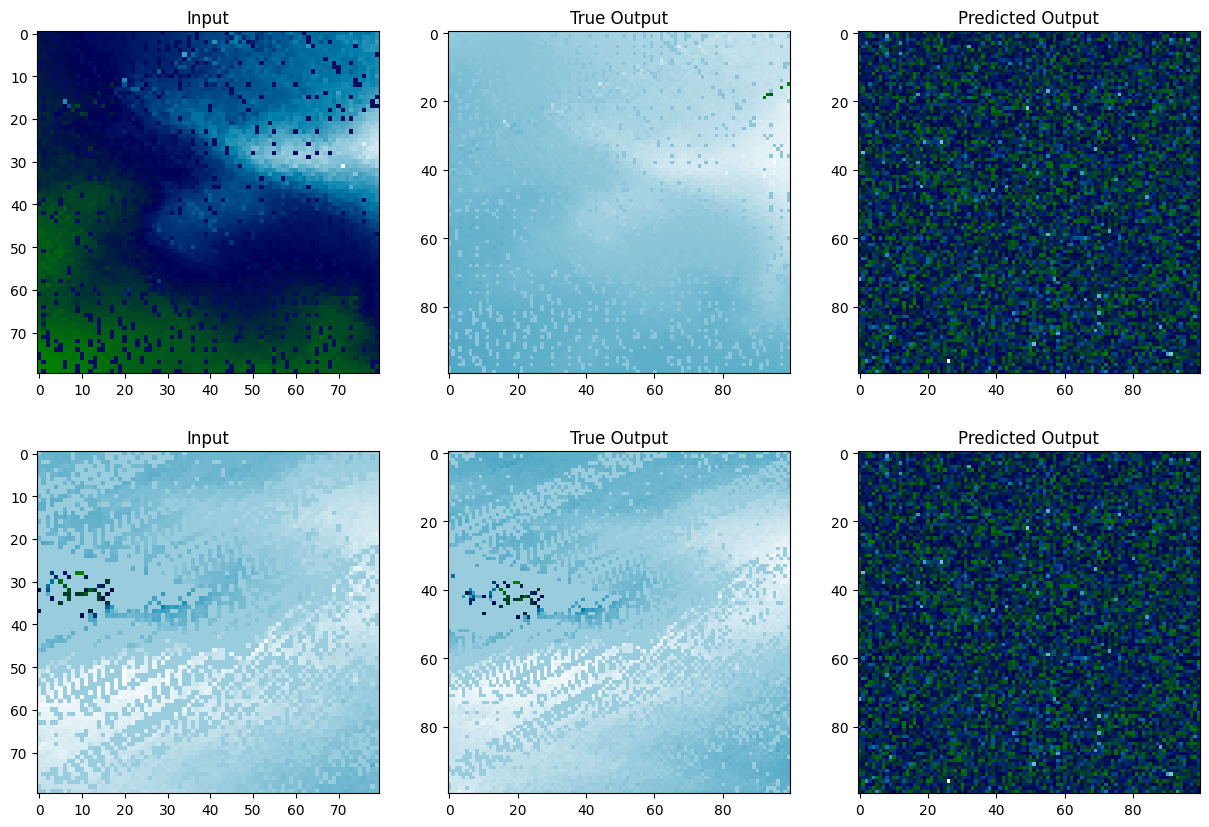

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(X_test[1000].reshape(80,80),cmap='ocean')
ax1.set_title('Input')
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(y_test[1000].reshape(100,100),cmap='ocean')
ax2.set_title('True Output')
ax3 = fig.add_subplot(2,3,3)
ax3.imshow(y_pred_cnn[1000].reshape(100,100),cmap='ocean')
ax3.set_title('Predicted Output')
ax4 = fig.add_subplot(2,3,4)
ax4.imshow(X_test[-1000].reshape(80,80),cmap='ocean')
ax4.set_title('Input')
ax5 = fig.add_subplot(2,3,5)
ax5.imshow(y_test[-1000].reshape(100,100),cmap='ocean')
ax5.set_title('True Output')
ax6 = fig.add_subplot(2,3,6)
ax6.imshow(y_pred_cnn[-1000].reshape(100,100),cmap='ocean')
ax6.set_title('Predicted Output')

### Batch Normalization

In [ ]:
class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)

        # Activation function
        self.relu = nn.ReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 6400, 256)
        self.fc2 = nn.Linear(256, 10000)

    def forward(self, x):
        # Reshape the input to (batch_size, num_channels, sequence_length)
        x = x.unsqueeze(1)

        # Convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
model = CNN_BN().to(device)

In [ ]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(filter_input_data[:15000,:], filter_target_data[:15000,:], test_size=0.15, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Creating the dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for t, (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if t % 100 == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (epoch+1, t, loss.item()))

# Save model
with open(path+'cnn_model_bn_128.pickle', 'wb') as handle:
    pickle.dump(model, handle)

Epoch 1, Iteration 0, loss = 10136867.0000
Epoch 2, Iteration 0, loss = 113987.0469
Epoch 3, Iteration 0, loss = 29981.5742
Epoch 4, Iteration 0, loss = 74457.6328
Epoch 5, Iteration 0, loss = 59840.9453
Epoch 6, Iteration 0, loss = 71525.1797
Epoch 7, Iteration 0, loss = 36446.5820
Epoch 8, Iteration 0, loss = 31383.4609
Epoch 9, Iteration 0, loss = 89400.5078
Epoch 10, Iteration 0, loss = 68495.4375
Epoch 11, Iteration 0, loss = 28624.2109
Epoch 12, Iteration 0, loss = 39614.4805
Epoch 13, Iteration 0, loss = 34646.0391
Epoch 14, Iteration 0, loss = 136466.1406
Epoch 15, Iteration 0, loss = 19427.0703
Epoch 16, Iteration 0, loss = 24440.2578
Epoch 17, Iteration 0, loss = 32534.1660
Epoch 18, Iteration 0, loss = 54898.1875
Epoch 19, Iteration 0, loss = 64198.9727
Epoch 20, Iteration 0, loss = 62713.5352
Epoch 21, Iteration 0, loss = 37572.1641
Epoch 22, Iteration 0, loss = 110548.9922
Epoch 23, Iteration 0, loss = 33299.5078
Epoch 24, Iteration 0, loss = 62939.6602
Epoch 25, Iteration

In [ ]:
# Evaluation
with torch.no_grad():
    model.eval()

    # Make predictions on test data
    X_test_tensor = X_test_tensor.to(device)
    test_outputs = model(X_test_tensor)

    # Calculate the evaluation metric: MSE
    y_test_cuda = y_test_tensor.to(device)
    evaluation_metric = criterion(test_outputs, y_test_cuda)

    # Calculate the evaluation metric: SSIM
    ssim_score_cnn = ssim_score(test_outputs.cpu().detach().numpy(), y_test_tensor.numpy())


# Print the evaluation metric
print("MSE:", evaluation_metric.item())
print("Average SSIM:", ssim_score_cnn)

MSE: 11464.51953125
Average SSIM: 0.6955812956765647


In [ ]:
_, X_test_3, _, y_test_3 = train_test_split(filter_input_data, filter_target_data, test_size=0.3, random_state=42)

In [ ]:
temp = model(torch.from_numpy(X_test_3[0].reshape(1,-1)).float().to(device))

In [ ]:
y_pred_cnn_bn = test_outputs.cpu().detach().numpy()

Text(0.5, 1.0, 'Predicted Output')

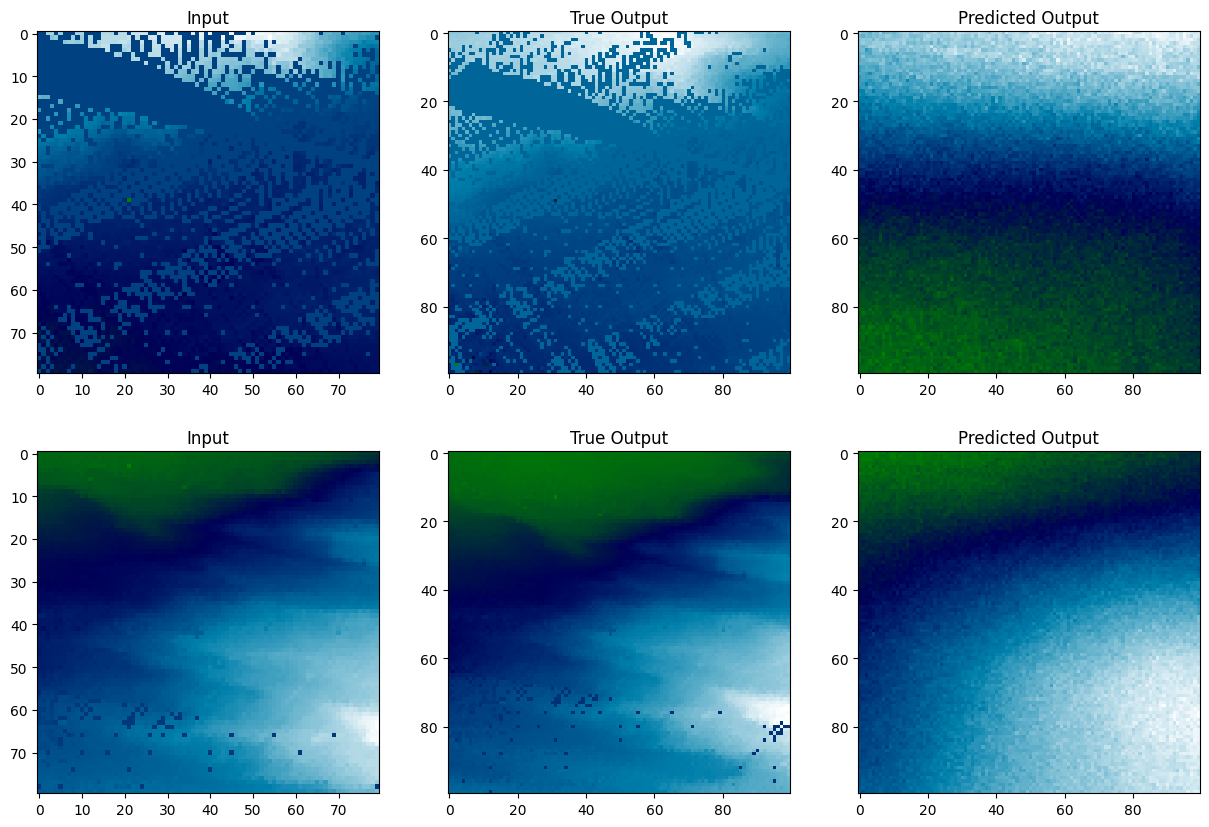

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(X_test_3[0].reshape(80,80),cmap='ocean')
ax1.set_title('Input')
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(y_test_3[0].reshape(100,100),cmap='ocean')
ax2.set_title('True Output')
ax3 = fig.add_subplot(2,3,3)
ax3.imshow(temp.cpu().detach().numpy().reshape(100,100),cmap='ocean')
ax3.set_title('Predicted Output')
ax4 = fig.add_subplot(2,3,4)
ax4.imshow(X_test[-1].reshape(80,80),cmap='ocean')
ax4.set_title('Input')
ax5 = fig.add_subplot(2,3,5)
ax5.imshow(y_test[-1].reshape(100,100),cmap='ocean')
ax5.set_title('True Output')
ax6 = fig.add_subplot(2,3,6)
ax6.imshow(y_pred_cnn_bn[-1].reshape(100,100),cmap='ocean')
ax6.set_title('Predicted Output')

## UNet Pretrained

In [ ]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, batch_norm=False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=mid_channel, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, padding=1)

        self.batch_norm = batch_norm
        if batch_norm:
            self.bn1 = nn.BatchNorm2d(mid_channel)
            self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(self.bn1(x)) if self.batch_norm else self.relu(x)

        x = self.conv2(x)
        x = self.relu(self.bn2(x)) if self.batch_norm else self.relu(x)
        return x

In [ ]:
class PretrainedUNet(torch.nn.Module):
    def up(self, x, size):
        return nn.functional.interpolate(x, size=size, mode=self.upscale_mode)

    def down(self, x):
        return nn.functional.max_pool2d(x, kernel_size=2)

    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode

        self.relu = nn.ReLU(inplace=True)

        self.init_conv = nn.Conv2d(in_channels, 3, 1)

        endcoder = torchvision.models.vgg11(pretrained=True).features
        self.conv1 = endcoder[0]
        self.conv2 = endcoder[3]
        self.conv3 = endcoder[6]
        self.conv3s = endcoder[8]
        self.conv4 = endcoder[11]
        self.conv4s = endcoder[13]
        self.conv5 = endcoder[16]
        self.conv5s = endcoder[18]

        self.center = Block(512, 512, 256, batch_norm)

        self.dec5 = Block(768, 512, 256, batch_norm)
        self.dec4 = Block(768, 512, 128, batch_norm)
        self.dec3 = Block(384, 256, 64, batch_norm)
        self.dec2 = Block(192, 128, 32, batch_norm)
        self.dec1 = Block(96, 64, 32, batch_norm)

        self.out = nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        init_conv = self.relu(self.init_conv(x))

        enc1 = self.relu(self.conv1(init_conv))
        enc2 = self.relu(self.conv2(self.down(enc1)))
        enc3 = self.relu(self.conv3(self.down(enc2)))
        enc3 = self.relu(self.conv3s(enc3))
        enc4 = self.relu(self.conv4(self.down(enc3)))
        enc4 = self.relu(self.conv4s(enc4))
        enc5 = self.relu(self.conv5(self.down(enc4)))
        enc5 = self.relu(self.conv5s(enc5))

        center = self.center(self.down(enc5))

        dec5 = self.dec5(torch.cat([self.up(center, enc5.size()[-2:]), enc5], 1))
        dec4 = self.dec4(torch.cat([self.up(dec5, enc4.size()[-2:]), enc4], 1))
        dec3 = self.dec3(torch.cat([self.up(dec4, enc3.size()[-2:]), enc3], 1))
        dec2 = self.dec2(torch.cat([self.up(dec3, enc2.size()[-2:]), enc2], 1))
        dec1 = self.dec1(torch.cat([self.up(dec2, enc1.size()[-2:]), enc1], 1))

        x = self.out(dec1)

        return x

In [ ]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
model = PretrainedUNet( in_channels=1, out_channels=1,batch_norm=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:10<00:00, 49.6MB/s]


In [ ]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(filter_input_data, filter_target_data, test_size=0.03, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(1).reshape(-1,1,80,80)
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1).reshape(-1,1,100,100)
X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(1).reshape(-1,1,80,80)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1).reshape(-1,1,100,100)

# # Apply padding to the input data so it matches output shape
X_train_padded = nn.functional.pad(X_train_tensor, (10, 10, 10, 10),'reflect',0)
X_test_padded = nn.functional.pad(X_test_tensor, (10, 10, 10, 10),'reflect',0)

# # Create the dataset and dataloader
train_dataset = TensorDataset(X_train_padded, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for t, (inputs, targets) in enumerate(train_dataloader):
        inputs=inputs.to(device)
        targets=targets.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if t % 100 == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (epoch+1, t, loss.item()))


with open(path+'pickle/unet_model_test.pickle', 'wb') as handle:
    pickle.dump(model, handle)

In [ ]:
with open(path+'pickle/unet_model_test.pickle', 'rb') as handle:
    model =  pickle.load(handle)

In [ ]:
# Splitting the data into train and test sets
_, X_test, _, y_test = train_test_split(filter_input_data, filter_target_data, test_size=0.03, random_state=42)

# Converting data to PyTorch tensors
X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(1).reshape(-1,1,80,80)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1).reshape(-1,1,100,100)

# Make test dataloader
test_dataset = TensorDataset(X_test_padded, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# # Apply padding to the input data so it matches output shape
X_test_padded = nn.functional.pad(X_test_tensor, (10, 10, 10, 10),'reflect',0)

In [ ]:
# Evaluation
with torch.no_grad():
    model.eval()
    X_test_padded=X_test_padded.to(device)
    # Make predictions on test data
    test_outputs = model(X_test_padded)
    y_test_tensor=y_test_tensor.to(device)
    # Calculate the evaluation metric: MSE
    evaluation_metric = criterion(test_outputs, y_test_tensor)

    # Calculate the evaluation metric: SSIM
    ssim_score_cnn = ssim_score(test_outputs.cpu().detach().numpy().reshape(-1,100,100), y_test_tensor.cpu().detach().numpy().reshape(-1,100,100))

# Print the evaluation metric
print("UNet MSE:", evaluation_metric.item())
print("UNet Average SSIM:", ssim_score_cnn)

OutOfMemoryError: ignored

In [ ]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(filter_input_data[:5000,:], filter_target_data[:5000,:], test_size=0.1, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(1).reshape(-1,1,80,80)
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1).reshape(-1,1,100,100)
X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(1).reshape(-1,1,80,80)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1).reshape(-1,1,100,100)

# # Apply padding to the input data so it matches output shape
X_train_padded = nn.functional.pad(X_train_tensor, (10, 10, 10, 10),'reflect',0)
X_test_padded = nn.functional.pad(X_test_tensor, (10, 10, 10, 10),'reflect',0)

# # Creating the dataset and dataloader
train_dataset = TensorDataset(X_train_padded, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    for t, (inputs, targets) in enumerate(train_dataloader):
        inputs=inputs.to(device)
        targets=targets.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if t % 100 == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (epoch+1, t, loss.item()))


with open(path+'pickle/unet_model_test.pickle', 'wb') as handle:
    pickle.dump(model, handle)

Epoch 1, Iteration 0, loss = 10236624.0000


In [ ]:
# Evaluation
with torch.no_grad():
    model.eval()
    X_test_padded=X_test_padded.to(device)
    # Make predictions on test data
    test_outputs = model(X_test_padded)
    y_test_tensor=y_test_tensor.to(device)
    # Calculate the evaluation metric: MSE
    evaluation_metric = criterion(test_outputs, y_test_tensor)

    # Calculate the evaluation metric: SSIM
    ssim_score_cnn = ssim_score(test_outputs.cpu().detach().numpy().reshape(-1,100,100), y_test_tensor.cpu().detach().numpy().reshape(-1,100,100))

# Print the evaluation metric
print("UNet MSE:", evaluation_metric.item())
print("UNet Average SSIM:", ssim_score_cnn)

UNet MSE: 10876770.0
UNet Average SSIM: 0.8887855239965856


In [ ]:
temp = X_test_padded[0].reshape(1,1,100,100).to(device)
test_output = model(temp)
y_pred_unet = test_output.cpu().detach().numpy()

In [ ]:
i = 300
temp2 = X_test_padded[i].reshape(1,1,100,100).to(device)
test_output = model(temp2)
y_pred_unet2 = test_output.cpu().detach().numpy()

In [ ]:
y_pred_unet = test_outputs.numpy()

Text(0.5, 1.0, 'Predicted Output')

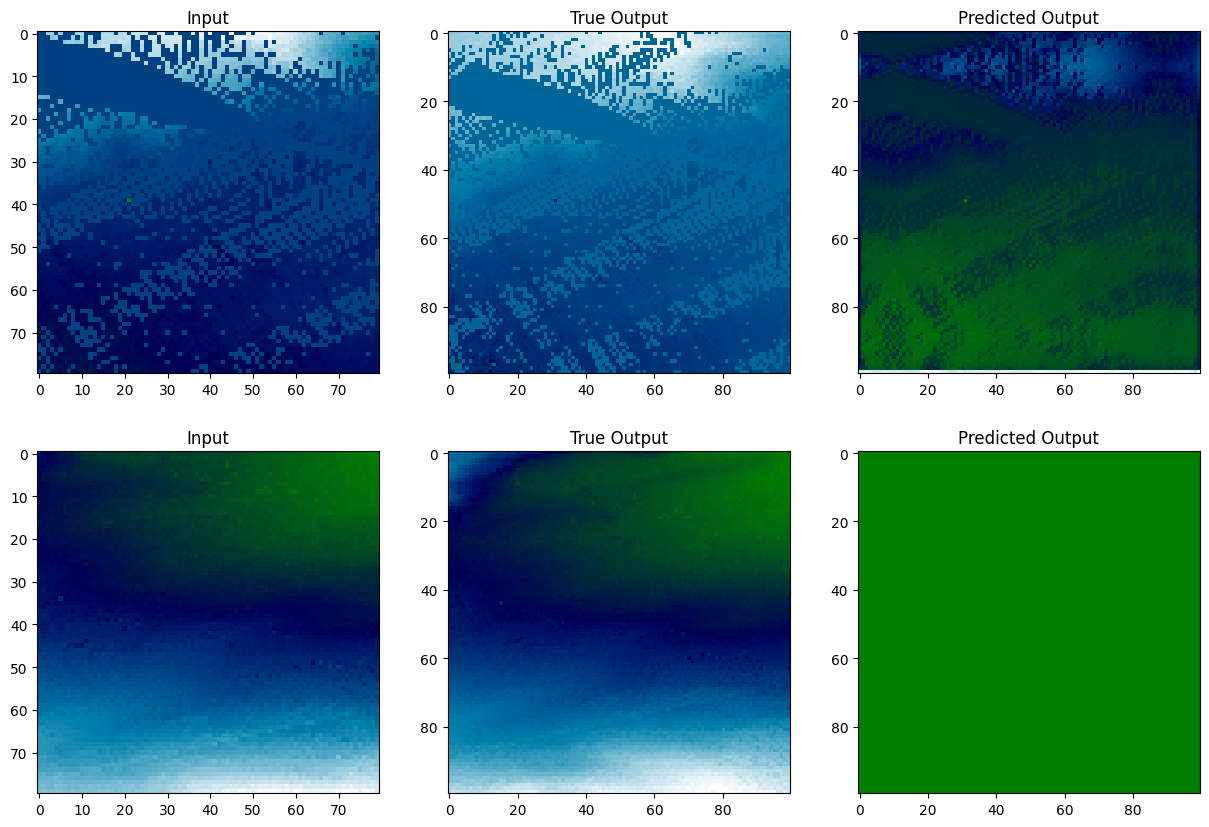

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(X_test[0].reshape(80,80),cmap='ocean')
ax1.set_title('Input')
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(y_test[0].reshape(100,100),cmap='ocean')
ax2.set_title('True Output')
ax3 = fig.add_subplot(2,3,3)
ax3.imshow(y_pred_unet.reshape(100,100),cmap='ocean')
ax3.set_title('Predicted Output')
ax4 = fig.add_subplot(2,3,4)
ax4.imshow(X_test[i].reshape(80,80),cmap='ocean')
ax4.set_title('Input')
ax5 = fig.add_subplot(2,3,5)
ax5.imshow(y_test[i].reshape(100,100),cmap='ocean')
ax5.set_title('True Output')
ax6 = fig.add_subplot(2,3,6)
ax6.imshow(y_pred_unet2.reshape(100,100),cmap='ocean')
ax6.set_title('Predicted Output')

## UNet memory trial error

In [ ]:
model = PretrainedUNet( in_channels=1, out_channels=1,batch_norm=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(filter_input_data[:5000,:], filter_target_data[:5000,:], test_size=0.1, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(1).reshape(-1,1,80,80)
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1).reshape(-1,1,100,100)
X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(1).reshape(-1,1,80,80)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1).reshape(-1,1,100,100)

# # Apply padding to the input data
X_train_padded = nn.functional.pad(X_train_tensor, (10, 10, 10, 10),'reflect',0)
X_test_padded = nn.functional.pad(X_test_tensor, (10, 10, 10, 10),'reflect',0)

# print(X_train_padded.shape)
# # Creating the dataset and dataloader
train_dataset = TensorDataset(X_train_padded, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for t, (inputs, targets) in enumerate(train_dataloader):
        inputs=inputs.to(device)
        targets=targets.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if t % 100 == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (epoch+1, t, loss.item()))

with open(path+'unet_model_128_new.pickle', 'wb') as handle:
    pickle.dump(model, handle)

Epoch 1, Iteration 0, loss = 9804271.0000
Epoch 2, Iteration 0, loss = 10294809.0000
Epoch 3, Iteration 0, loss = 11326259.0000
Epoch 4, Iteration 0, loss = 10201059.0000
Epoch 5, Iteration 0, loss = 10555954.0000
Epoch 6, Iteration 0, loss = 10373732.0000
Epoch 7, Iteration 0, loss = 11108730.0000
Epoch 8, Iteration 0, loss = 10526494.0000
Epoch 9, Iteration 0, loss = 10572957.0000
Epoch 10, Iteration 0, loss = 11601071.0000
Epoch 11, Iteration 0, loss = 11117449.0000
Epoch 12, Iteration 0, loss = 10629911.0000
Epoch 13, Iteration 0, loss = 10395803.0000
Epoch 14, Iteration 0, loss = 10716056.0000
Epoch 15, Iteration 0, loss = 10884433.0000
Epoch 16, Iteration 0, loss = 11033014.0000
Epoch 17, Iteration 0, loss = 11096821.0000
Epoch 18, Iteration 0, loss = 10807166.0000
Epoch 19, Iteration 0, loss = 10630825.0000
Epoch 20, Iteration 0, loss = 10839275.0000
Epoch 21, Iteration 0, loss = 11291200.0000
Epoch 22, Iteration 0, loss = 10294340.0000
Epoch 23, Iteration 0, loss = 10402010.000

In [ ]:
# Evaluation
with torch.no_grad():
    model.eval()
    X_test_padded=X_test_padded.to(device)
    # Make predictions on test data
    test_outputs = model(X_test_padded)
    y_test_tensor=y_test_tensor.to(device)
    # Calculate the evaluation metric: MSE
    evaluation_metric = criterion(test_outputs, y_test_tensor)

    # Calculate the evaluation metric: SSIM
    ssim_score_cnn = ssim_score(test_outputs.cpu().detach().numpy().reshape(-1,100,100), y_test_tensor.cpu().detach().numpy().reshape(-1,100,100))

# Print the evaluation metric
print("UNet MSE:", evaluation_metric.item())
print("UNet Average SSIM:", ssim_score_cnn)

UNet MSE: 6032811.0
UNet Average SSIM: 0.8478967754408537


In [ ]:
_, X_test_3, _, y_test_3 = train_test_split(filter_input_data, filter_target_data, test_size=0.3, random_state=42)
X_test_3_tensor = torch.from_numpy(X_test_3[0]).float().unsqueeze(1).reshape(-1,1,80,80)
X_test_3_padded = nn.functional.pad(X_test_3_tensor, (10, 10, 10, 10),'reflect',0)
temp = model(X_test_3_padded.to(device))

y_pred_cnn_bn = test_outputs.cpu().detach().numpy()

In [ ]:
np.save(path+'y_test_image.npy', y_test_3[0].reshape(100,100))

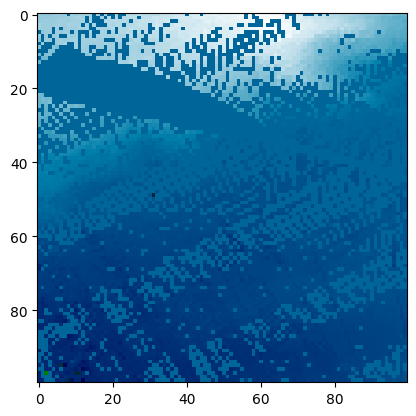

In [ ]:
plt.imshow(y_test_3[0].reshape(100,100),cmap='ocean')

Text(0.5, 1.0, 'Predicted Output')

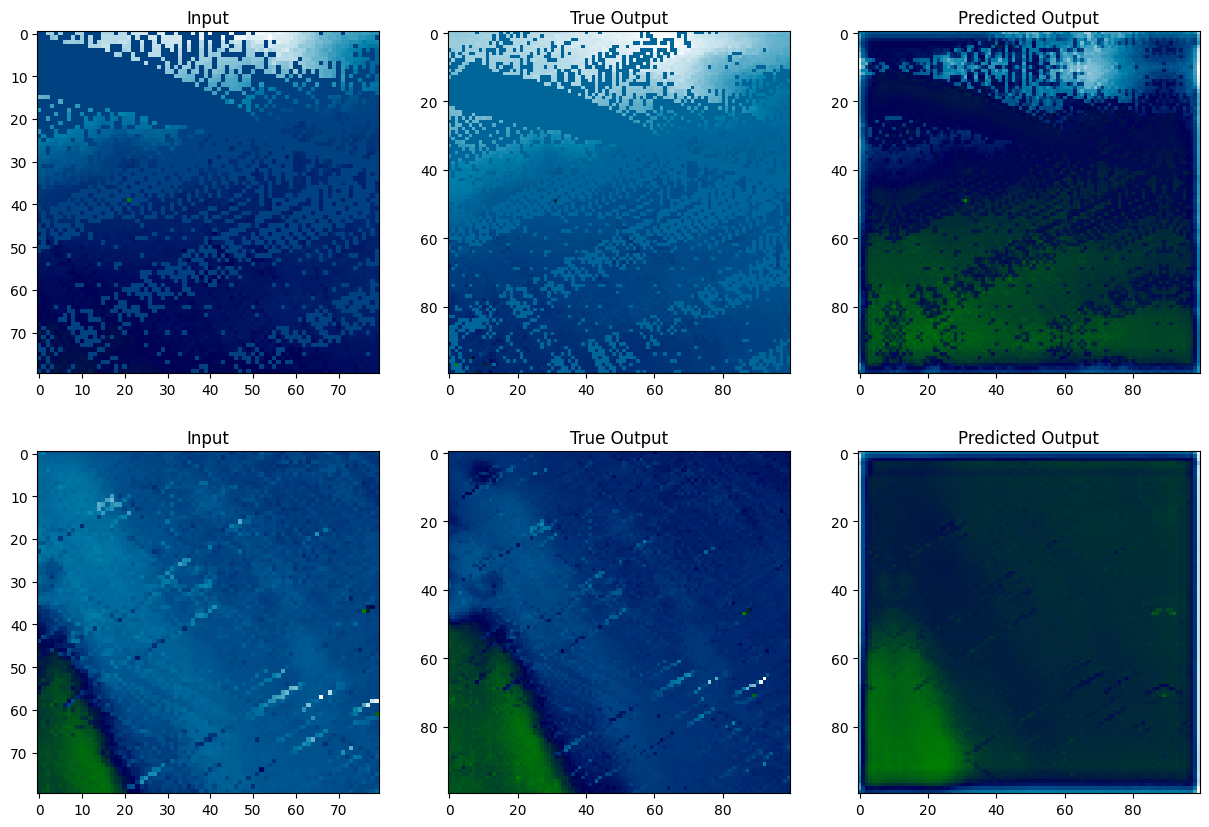

In [ ]:
i = 268
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(X_test_3[0].reshape(80,80),cmap='ocean')
ax1.set_title('Input')
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(y_test_3[0].reshape(100,100),cmap='ocean')
ax2.set_title('True Output')
ax3 = fig.add_subplot(2,3,3)
ax3.imshow(temp.cpu().detach().numpy().reshape(100,100),cmap='ocean')
ax3.set_title('Predicted Output')
ax4 = fig.add_subplot(2,3,4)
ax4.imshow(X_test[i].reshape(80,80),cmap='ocean')
ax4.set_title('Input')
ax5 = fig.add_subplot(2,3,5)
ax5.imshow(y_test[i].reshape(100,100),cmap='ocean')
ax5.set_title('True Output')
ax6 = fig.add_subplot(2,3,6)
ax6.imshow(y_pred_cnn_bn[i].reshape(100,100),cmap='ocean')
ax6.set_title('Predicted Output')